In [1]:
import numpy as np
from matplotlib import pyplot as plt

import snntorch as snn
from snntorch import spikegen
import snntorch.functional as SF

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import load_model

import pandas as pd
import json

import cv2

from sklearn.model_selection import train_test_split

In [2]:
dtype = torch.float

In [3]:
device = "cpu"

In [4]:
ENV = 1
CODE_SIZE = 500
TRAIN_SIZE = 0.20
TEST_NORMAL_SAMPLES = 600
TEST_ANOMALY_SAMPLES = 600
BATCH_SIZE = 32
PRE_TRAIN_EPOCHS = 20
EPOCHS_PER_FRAME = 10
SIGMA = 1.5
LAMBDA = 0.5 # 0.1

# Data Preprocessing and Loading

In [5]:
def log_resize(img):
        
    h, w = img.shape[:2]
    cx, cy = w // 2, h // 2  # Centro
    d = np.sqrt(cx**2 + cy**2)  # Distanza massima

    # Parametri per modulare l'effetto
    alpha = 0.05  # Prova ad aumentarlo se la maschera è troppo piatta
    beta = 5 # Abbassa per rendere meno espansa la zona centrale

    # Creazione della maschera lineare, puoi anche sperimentare con altre funzioni
    Y, X = np.meshgrid(np.arange(h), np.arange(w), indexing="ij")
    distance = np.sqrt((X - cx) ** 2 + (Y - cy) ** 2)

    # Modifica della formula per la maschera
    mask = (distance / d)  # Usa una relazione lineare per la distanza
    mask = 1 - alpha * mask  # Inverti per dare più peso al centro
    mask = np.clip(mask, 0, 1)  # Mantieni valori tra 0 e 1

    # Debug: Controlla i valori della maschera
    #print(f"Valori maschera (min, max): {mask.min()}, {mask.max()}")

    # Applica la maschera direttamente all'immagine in scala di grigi
    img_weighted = img * mask

    # Debug: Controlla i valori dell'immagine pesata
    #print(f"Valori immagine pesata (min, max): {img_weighted.min()}, {img_weighted.max()}")

    # Converti a uint8
    img_weighted = np.clip(img_weighted, 0, 255).astype(np.uint8)

    # Ridimensiona a 28x28
    img_resized = cv2.resize(img_weighted, (28, 28), interpolation=cv2.INTER_AREA)

    return img_resized

In [6]:
with open("training_mixed_set/envs_mapping.txt","r") as f:
    envs_mapping= json.loads(f.read())
envs_mapping

{'underground': 0, '1long': 1, '1short': 2}

In [7]:
with open("training_mixed_set/labels_mapping.txt","r") as f:
    labels_mapping= json.loads(f.read())
labels_mapping

{'normal': 0,
 'box': 1,
 'cable': 2,
 'cones': 3,
 'debris': 4,
 'defects': 5,
 'door': 6,
 'floor': 7,
 'human': 8,
 'misc': 9,
 'tape': 10,
 'trolley': 11,
 'clutter': 12,
 'foam': 13,
 'sawdust': 14,
 'shard': 15,
 'cellophane': 16,
 'screws': 17,
 'water': 18,
 'obj. on robot': 19,
 'obj. on robot2': 20}

In [8]:
env_df = pd.read_csv("training_mixed_set/training_mixed_set_frames_envs.csv")
env_df.head()

,frame_id,env
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [9]:
label_df = pd.read_csv("training_mixed_set/training_mixed_frames_labels.csv")
label_df.head()

,frame_id,label
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [10]:
len(env_df)

144603

In [11]:
len(label_df)

144603

In [12]:
data_df = pd.merge(env_df,label_df,how="left")

In [13]:
data_df.head()

,frame_id,env,label
0,0,1,1
1,1,1,1
2,2,1,1
3,3,1,1
4,4,1,1


In [14]:
normal_df = data_df[(data_df["env"] == ENV) & (data_df["label"] == 0)].reset_index(drop=True)

In [15]:
normal_df["frame_id"] =  normal_df["frame_id"].astype(str).str.zfill(6)

In [16]:
normal_df.head()

,frame_id,env,label
0,094362,1,0
1,094363,1,0
2,094364,1,0
3,094365,1,0
4,094366,1,0


In [17]:
len(normal_df)

15655

In [18]:
anomaly_df = data_df[(data_df["env"] == ENV) & ((data_df["label"] == 8))].reset_index(drop=True)

In [19]:
anomaly_df["frame_id"] =  anomaly_df["frame_id"].astype(str).str.zfill(6)

In [20]:
anomaly_df.head()

,frame_id,env,label
0,009753,1,8
1,009754,1,8
2,009755,1,8
3,009756,1,8
4,009757,1,8


In [21]:
len(anomaly_df)

5946

In [22]:
train_df, rem_df = train_test_split(normal_df,train_size=TRAIN_SIZE,shuffle=False)

In [23]:
len(train_df)

3131

In [24]:
len(rem_df)

12524

In [25]:
train_df.reset_index(drop=True,inplace=True)

In [26]:
train_df.head()

,frame_id,env,label
0,094362,1,0
1,094363,1,0
2,094364,1,0
3,094365,1,0
4,094366,1,0


In [27]:
test_df = pd.concat([rem_df.iloc[0:TEST_NORMAL_SAMPLES],anomaly_df.iloc[0:TEST_ANOMALY_SAMPLES]]).reset_index(drop=True)

In [28]:
test_df.head()

,frame_id,env,label
0,097493,1,0
1,097494,1,0
2,097495,1,0
3,097496,1,0
4,097497,1,0


In [29]:
X_train = []
for i in range(len(train_df)):
    path = "training_mixed_set/unlabeled_set/"+train_df.iloc[i]["frame_id"]+"_512_512.jpg"
    img = cv2.imread(path,0)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.resize(img, (28, 28))
    img = log_resize(img)
    X_train.append(img)
X_train = (np.array(X_train)/255.0).astype(float)

In [30]:
X_train[0].shape

(28, 28)

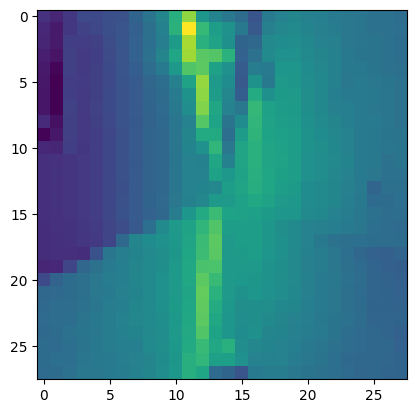

In [31]:
plt.imshow(X_train[0])

In [32]:
X_test = []
for i in range(len(test_df)):
    path = "training_mixed_set/unlabeled_set/"+test_df.iloc[i]["frame_id"]+"_512_512.jpg"
    img = cv2.imread(path,0)
    img = cv2.resize(img, (224, 224))
    X_test.append(img)
X_test = (np.array(X_test)/255.0).astype(float)

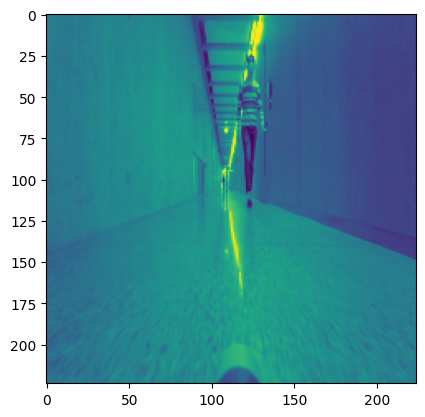

In [33]:
plt.imshow(X_test[-1])

In [34]:
X_test_lr = []
for i in range(len(test_df)):
    path = "training_mixed_set/unlabeled_set/"+test_df.iloc[i]["frame_id"]+"_512_512.jpg"
    img = cv2.imread(path,0)
    img = log_resize(img)
    X_test_lr.append(img)
X_test_lr = (np.array(X_test_lr)/255.0).astype(float)

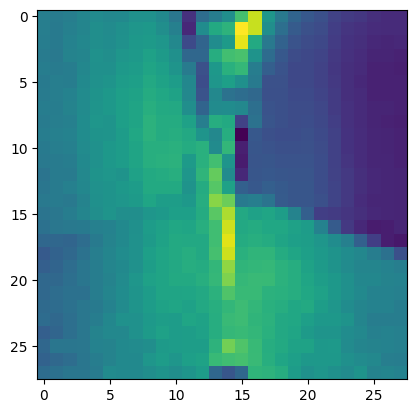

In [35]:
plt.imshow(X_test_lr[-1])

In [36]:
X_train = np.reshape(X_train,(-1,784))
X_train.shape

(3131, 784)

In [37]:
y_train = np.array(train_df["label"])
y_train.shape

(3131,)

In [38]:
X_test = np.reshape(X_test,(-1,224,224,1))
X_test.shape

(1200, 224, 224, 1)

In [39]:
X_test_lr = np.reshape(X_test_lr,(-1,784))
X_test_lr.shape

(1200, 784)

In [40]:
y_test = np.array(test_df["label"])
y_test = (y_test != 0).astype(int)
y_test.shape

(1200,)

In [41]:
sum(y_test == 0)

np.int64(600)

In [42]:
sum(y_test == 1)

np.int64(600)

# Utility Functions

In [43]:
def train(model,train_dataloader,val_dataloader,epochs,loss_fn,optimizer):
    
    train_losses = []
    val_losses = []

    for e in range(epochs):
        train_batch = iter(train_dataloader)
    
        train_loss_epoch = 0
        val_loss_epoch = 0
    
        for data, targets in tqdm(train_batch):
            data = data.to(device)
            targets = targets.to(device)
        
            model.train()
            spk_rec, mem_rec = model(data.view(len(data), -1))

            loss_val = torch.zeros((1), dtype=dtype, device=device)
            for step in range(model.num_steps):
                loss_val += loss_fn(mem_rec[step], targets)
                #spk_rec
         
            train_loss_epoch += loss_val.item()

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            with torch.no_grad():
                model.eval()
                val_data, val_targets = next(iter(val_dataloader))
                val_data = val_data.to(device)
                val_targets = val_targets.to(device)

                val_spk, val_mem = model(val_data.view(len(val_data), -1))

                val_loss = torch.zeros((1), dtype=dtype, device=device)
                for step in range(model.num_steps):
                    val_loss += loss_fn(val_mem[step], val_targets)
                    #val_spk
                
                #recon = torch.mean(val_mem,axis=0)
                #val_loss = loss_fn(recon,val_targets)
        
            val_loss_epoch += val_loss.item()
        
        print(f"Train loss at epoch: {e+1}: {train_loss_epoch}")
        print(f"Val loss at epoch: {e+1}: {val_loss_epoch}")
    
        train_losses.append(train_loss_epoch)
        val_losses.append(val_loss_epoch)
    
    return train_losses,val_losses

In [44]:
class IncrementalLoss(nn.Module):
    def __init__(self, lambda_=0.1):
        super(IncrementalLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.lambda_ = lambda_
        self.previous_weights = None 

    def set_previous_weights(self, model):
        self.previous_weights = {name: param.clone().detach() for name, param in model.named_parameters()}

    def forward(self, predictions, targets, model):
        loss_mse = self.mse(predictions, targets)

        if self.previous_weights is None:
            return loss_mse

        weight_penalty = 0.0
        param_count = 0
        for name, param in model.named_parameters():
            if name in self.previous_weights:
                diff = param - self.previous_weights[name]
                weight_penalty += torch.sum(diff ** 2)
                param_count += diff.numel()
        
    
        scale_factor = loss_mse.item() / (weight_penalty.item() + 1e-8)  
        total_loss = loss_mse + self.lambda_ * scale_factor * weight_penalty
        
        #print("MSE: ", loss_mse)
        #print("Weight penalty: ", self.lambda_ * scale_factor * weight_penalty)
    
        return total_loss

In [45]:
def magic_train(model,train_dataloader,val_dataloader,epochs,loss_fn,optimizer):
    
    train_losses = []

    for e in range(epochs):
        train_batch = iter(train_dataloader)
    
        train_loss_epoch = 0
        val_loss_epoch = 0
    
        for data, targets in tqdm(train_batch):
            data = data.to(device)
            targets = targets.to(device)
        
            model.train()
            spk_rec, mem_rec = model(data.view(len(data), -1))

            loss_val = torch.zeros((1), dtype=dtype, device=device)
            for step in range(model.num_steps):
                loss_val += loss_fn(mem_rec[step], targets, model)
            
            #recon = torch.mean(mem_rec,axis=0)
            #loss_val = loss_fn(recon,targets,model)
            
            train_loss_epoch += loss_val.item()

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
        
        print(f"Train loss at epoch: {e+1}: {train_loss_epoch}")
    
        train_losses.append(train_loss_epoch)
    
    return train_losses

In [46]:
def compute_reconstruction_error(model,sample):
    model.eval()
    spk,mem = model(sample)
    mem = torch.mean(mem,axis=0)
    mse = torch.nn.MSELoss()
    return mse(sample,mem).item()

In [84]:
def compute_reconstructions(model,sample):
    model.eval()
    spk,mem = model(sample)
    mem = torch.mean(mem,axis=0)
    error = torch.square(sample - mem)
    error = torch.mean(error,axis=1)
    return error

In [48]:
# Cose da attenzionare:

# 1) Normalizzazione del lambda ===> Fatto
# 2) Pre-allenamento su un gruppo normale (senza usare incremental) ====> Fatto
# 3) Possibilità di rendere dinamico l'hidden layer (Future works)
# 4) Valutazione FP, FN al variare threshold ==> Fatto

# Magic Loop Pazzo Sgravato

In [49]:
class SAE(nn.Module):
    def __init__(self,num_inputs,num_hidden,num_steps=25,beta=0.95):
        super().__init__()
        
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_steps = num_steps
        self.beta = beta
        
        self.fc1 = nn.Linear(self.num_inputs,self.num_hidden)
        self.lif1 = snn.Leaky(beta=self.beta)
        self.fc2 = nn.Linear(self.num_hidden, self.num_inputs)
        self.lif2 = snn.Leaky(beta=self.beta)

    def forward(self, x):

        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        spk2_rec = []
        mem2_rec = []

        for step in range(self.num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [50]:
magic_sae = SAE(784,CODE_SIZE,num_steps=30)

In [51]:
magic_cnn = load_model("AD_Loop_base.keras")

In [52]:
magic_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,294,853 (4.94 MB)

 Trainable params: 431,617 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 863,236 (3.29 MB)

In [53]:
optimizer = torch.optim.Adam(magic_sae.parameters(), lr=1e-3, betas=(0.9, 0.999))

# Magic-SAE Pre-training

In [54]:
X_train = X_train[0:int(0.80*len(X_train))]
X_val = X_train[int(0.80*len(X_train)):]
X_train = torch.Tensor(X_train)
X_val = torch.Tensor(X_val)

In [55]:
pre_train_dataset = TensorDataset(X_train,X_train)
pre_train_dataloader = DataLoader(pre_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val,X_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

loss_fn = torch.nn.MSELoss()
train_losses, val_losses = train(magic_sae,pre_train_dataloader,val_dataloader,PRE_TRAIN_EPOCHS,loss_fn,optimizer)

100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.18it/s]


Train loss at epoch: 1: 213.40896701812744
Val loss at epoch: 1: 197.86415088176727


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.19it/s]


Train loss at epoch: 2: 102.44403541088104
Val loss at epoch: 2: 108.96896767616272


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.32it/s]


Train loss at epoch: 3: 84.87990212440491
Val loss at epoch: 3: 88.04810953140259


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.58it/s]


Train loss at epoch: 4: 82.03582108020782
Val loss at epoch: 4: 83.87089145183563


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.75it/s]


Train loss at epoch: 5: 81.59046709537506
Val loss at epoch: 5: 83.47465240955353


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.47it/s]


Train loss at epoch: 6: 82.069251537323
Val loss at epoch: 6: 84.75113463401794


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.22it/s]


Train loss at epoch: 7: 81.66688358783722
Val loss at epoch: 7: 83.30396556854248


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.53it/s]


Train loss at epoch: 8: 81.18190199136734
Val loss at epoch: 8: 82.81309449672699


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 22.28it/s]


Train loss at epoch: 9: 81.06864804029465
Val loss at epoch: 9: 82.62262296676636


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.62it/s]


Train loss at epoch: 10: 82.03078824281693
Val loss at epoch: 10: 83.2830240726471


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.41it/s]


Train loss at epoch: 11: 80.63647443056107
Val loss at epoch: 11: 82.10993003845215


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 22.04it/s]


Train loss at epoch: 12: 79.90666908025742
Val loss at epoch: 12: 81.48887753486633


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.64it/s]


Train loss at epoch: 13: 79.67154943943024
Val loss at epoch: 13: 80.69655191898346


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.43it/s]


Train loss at epoch: 14: 79.42529064416885
Val loss at epoch: 14: 80.74473732709885


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.35it/s]


Train loss at epoch: 15: 79.41942363977432
Val loss at epoch: 15: 81.01948463916779


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.41it/s]


Train loss at epoch: 16: 79.51612615585327
Val loss at epoch: 16: 80.69697088003159


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.04it/s]


Train loss at epoch: 17: 79.54343730211258
Val loss at epoch: 17: 80.76989209651947


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.41it/s]


Train loss at epoch: 18: 79.53567320108414
Val loss at epoch: 18: 80.59402674436569


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.47it/s]


Train loss at epoch: 19: 79.46648448705673
Val loss at epoch: 19: 80.37986016273499


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.83it/s]

Train loss at epoch: 20: 79.337242603302
Val loss at epoch: 20: 80.0823101401329


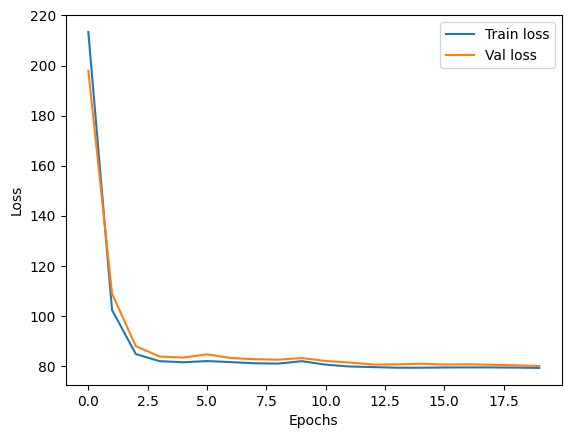

In [56]:
plt.plot(train_losses,label="Train loss")
plt.plot(val_losses,label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")

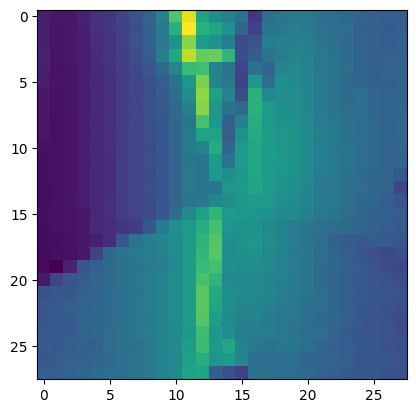

In [57]:
TRAIN_ID = 10
plt.imshow(X_train[TRAIN_ID].reshape(28,28))

In [58]:
magic_sae.eval()
a,b = magic_sae(torch.Tensor(X_train[TRAIN_ID]))

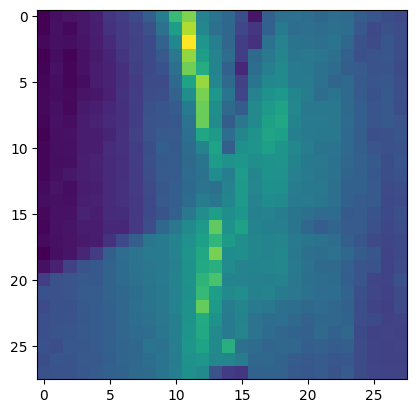

In [59]:
c = torch.mean(b,axis=0)
plt.imshow(c.detach().numpy().reshape(28,28))

# Threshold definition

In [60]:
THR = compute_reconstruction_error(magic_sae,X_train) * SIGMA
THR

0.012225085403770208

In [61]:
e = compute_reconstructions(magic_sae,X_train)
print(torch.mean(e))
print(torch.mean(e)*SIGMA)
print(torch.var(e))

tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MulBackward0>)
tensor(6.9997e-06, grad_fn=<VarBackward0>)


# Training with Pre-Trained SAE

In [62]:
frame_errors = []
preds = []
FP = []
FN = [] 

for frame in range(len(X_test)):
    
    # Low res
    sample = X_test_lr[frame]
    #sample = cv2.resize(sample, (28, 28))
    #sample = log_resize(sample)
    sample = torch.Tensor(sample)
    sample = torch.reshape(sample,(-1,784))
    frame_err = compute_reconstruction_error(magic_sae,sample)
    frame_errors.append(frame_err)

    # Anomaly detected
    if frame_err > THR:
        preds.append(1)
        if y_test[frame] == 0:
            FP.append(frame)
    else:
        preds.append(0)
        if y_test[frame] == 1:
            FN.append(frame)   

(0.0, 0.2)

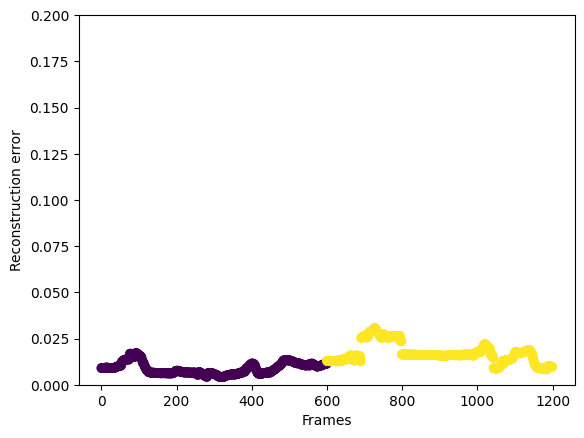

In [63]:
#plt.plot(frame_errors)
plt.scatter(np.arange(len(frame_errors)),frame_errors,c=y_test)
plt.xlabel("Frames")
plt.ylabel("Reconstruction error")
plt.ylim((0,0.2))

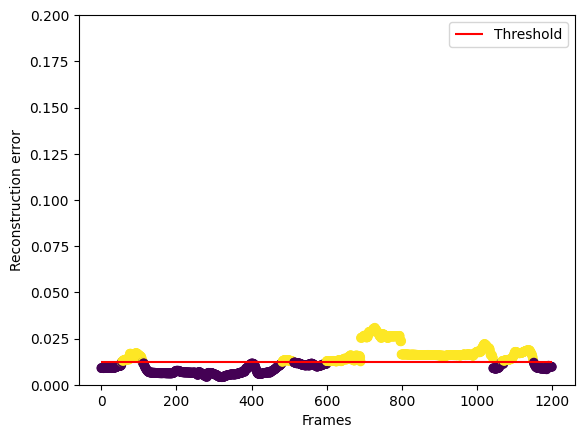

In [64]:
#plt.plot(frame_errors)
plt.scatter(np.arange(len(frame_errors)),frame_errors,c=preds)
plt.hlines(y=THR,xmin=0,xmax=len(frame_errors),color="red",label="Threshold")
plt.xlabel("Frames")
plt.ylabel("Reconstruction error")
plt.ylim((0,0.2))
plt.legend(loc="best")

In [65]:
print("False Positives: ", len(FP))
print("False Negatives: ", len(FN))

False Positives:  86
False Negatives:  74


In [66]:
loss_fn = IncrementalLoss(lambda_=LAMBDA)
optimizer = torch.optim.Adam(magic_sae.parameters(), lr=1e-3, betas=(0.9, 0.999)) # Prova

# Magic Training

In [67]:
frame_errors = []
preds = []
FP = []
FN = [] 

for frame in range(len(X_test)):
    
    # Low res
    sample = X_test_lr[frame]
    #sample = cv2.resize(sample, (28, 28))
    #sample = log_resize(sample)
    sample = torch.Tensor(sample)
    sample = torch.reshape(sample,(-1,784))
    frame_err = compute_reconstruction_error(magic_sae,sample)
    frame_errors.append(frame_err)

    # Anomaly detected
    if frame_err > THR:
        
        preds.append(1)
        
        # TO-DO:
        # p = magic_cnn()
        #...
  
        if y_test[frame] == 0:
            FP.append(frame)
            # Normal: We adapt the magic SAE
            print(f"Training on frame: {frame+1}")
            train_dataset = TensorDataset(sample,sample)
            train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False) 
            magic_train(magic_sae,train_dataloader,train_dataloader,EPOCHS_PER_FRAME,loss_fn,optimizer)
            loss_fn.set_previous_weights(magic_sae)
        else:
            # Anomaly: Nothing to do here, we recognized the anomaly
            pass
    else:
        
        preds.append(0)
        if y_test[frame] == 1:
            FN.append(frame)

Training on frame: 55


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 42.80it/s]


Train loss at epoch: 1: 1.265894889831543


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 41.99it/s]


Train loss at epoch: 2: 1.9253778457641602


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 43.87it/s]


Train loss at epoch: 3: 1.241243839263916


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 41.54it/s]


Train loss at epoch: 4: 1.2734366655349731


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 41.07it/s]


Train loss at epoch: 5: 1.171022891998291


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 42.74it/s]


Train loss at epoch: 6: 1.137270450592041


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.64it/s]


Train loss at epoch: 7: 1.3376582860946655


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 44.16it/s]


Train loss at epoch: 8: 1.078359603881836


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 43.13it/s]


Train loss at epoch: 9: 1.0368831157684326


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 42.48it/s]


Train loss at epoch: 10: 1.0621126890182495
Training on frame: 77


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.00it/s]


Train loss at epoch: 1: 1.2484902143478394


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.14it/s]


Train loss at epoch: 2: 1.7996220588684082


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.78it/s]


Train loss at epoch: 3: 1.6412029266357422


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.07it/s]


Train loss at epoch: 4: 1.5732345581054688


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.29it/s]


Train loss at epoch: 5: 1.520627737045288


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.90it/s]


Train loss at epoch: 6: 1.48479425907135


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.58it/s]


Train loss at epoch: 7: 1.465314507484436


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.83it/s]


Train loss at epoch: 8: 1.4607272148132324


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.88it/s]


Train loss at epoch: 9: 1.4634265899658203


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.27it/s]


Train loss at epoch: 10: 1.4646562337875366
Training on frame: 284


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.49it/s]


Train loss at epoch: 1: 1.1739970445632935


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.27it/s]


Train loss at epoch: 2: 1.6822164058685303


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.11it/s]


Train loss at epoch: 3: 1.5835039615631104


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.98it/s]


Train loss at epoch: 4: 1.4849565029144287


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.09it/s]


Train loss at epoch: 5: 1.4091520309448242


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.74it/s]


Train loss at epoch: 6: 1.364322304725647


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.52it/s]


Train loss at epoch: 7: 1.3462268114089966


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.69it/s]


Train loss at epoch: 8: 1.3401294946670532


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.07it/s]


Train loss at epoch: 9: 1.3424327373504639


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.87it/s]


Train loss at epoch: 10: 1.351113200187683


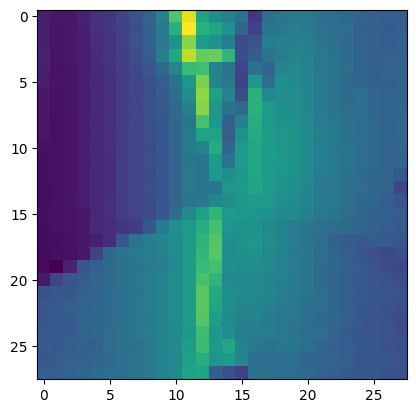

In [68]:
TRAIN_ID = 10
plt.imshow(X_train[TRAIN_ID].reshape(28,28))

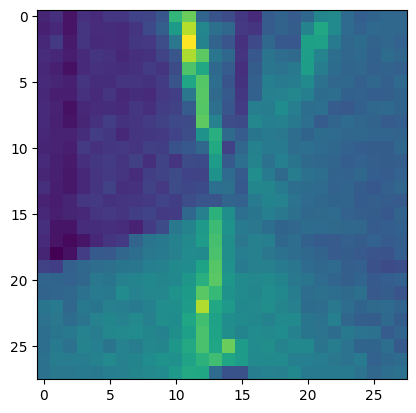

In [69]:
magic_sae.eval()
a,b = magic_sae(torch.Tensor(X_train[TRAIN_ID]))
c = torch.mean(b,axis=0)
plt.imshow(c.detach().numpy().reshape(28,28))

(0.0, 0.2)

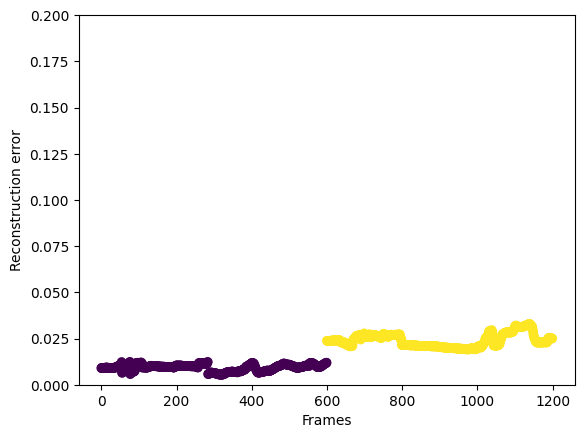

In [70]:
plt.scatter(np.arange(len(frame_errors)),frame_errors,c=y_test)
plt.xlabel("Frames")
plt.ylabel("Reconstruction error")
plt.ylim((0,0.2))

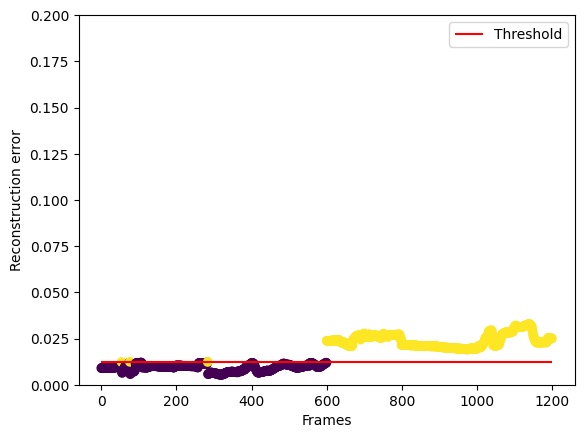

In [71]:
plt.scatter(np.arange(len(frame_errors)),frame_errors,c=preds)
plt.hlines(y=THR,xmin=0,xmax=len(frame_errors),color="red",label="Threshold")
plt.xlabel("Frames")
plt.ylabel("Reconstruction error")
plt.ylim((0,0.2))
plt.legend(loc="best")

In [72]:
print("False Positives: ", len(FP))
print("False Negatives: ", len(FN))

False Positives:  3
False Negatives:  0


In [93]:
FP

[54, 76, 283]

In [83]:
retrain_dataset = TensorDataset(torch.Tensor(X_test_lr[FP]),torch.Tensor(X_test_lr[FP]))
retrain_dataloader = DataLoader(retrain_dataset, batch_size=BATCH_SIZE, shuffle=True) 
magic_train(magic_sae,retrain_dataloader,retrain_dataloader,EPOCHS_PER_FRAME,loss_fn,optimizer)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.67it/s]


Train loss at epoch: 1: 1.0513321161270142


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.53it/s]


Train loss at epoch: 2: 1.547576665878296


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.20it/s]


Train loss at epoch: 3: 1.5264369249343872


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.99it/s]


Train loss at epoch: 4: 1.5103857517242432


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.96it/s]


Train loss at epoch: 5: 1.5016804933547974


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


Train loss at epoch: 6: 1.5053317546844482


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


Train loss at epoch: 7: 1.5231744050979614


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.22it/s]


Train loss at epoch: 8: 1.549401044845581


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.30it/s]


Train loss at epoch: 9: 1.5729093551635742


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.79it/s]

Train loss at epoch: 10: 1.582208275794983


[1.0513321161270142,
 1.547576665878296,
 1.5264369249343872,
 1.5103857517242432,
 1.5016804933547974,
 1.5053317546844482,
 1.5231744050979614,
 1.549401044845581,
 1.5729093551635742,
 1.582208275794983]

In [94]:
new_errors = compute_reconstructions(magic_sae,torch.Tensor(X_test_lr[FP]))

In [95]:
new_errors

tensor([0.0116, 0.0106, 0.0049], grad_fn=<MeanBackward1>)

In [96]:
new_errors < THR

tensor([True, True, True])

In [97]:
new_frame_errors = np.zeros(len(frame_errors))

In [99]:
new_frame_errors[FP] = new_errors.detach().numpy()

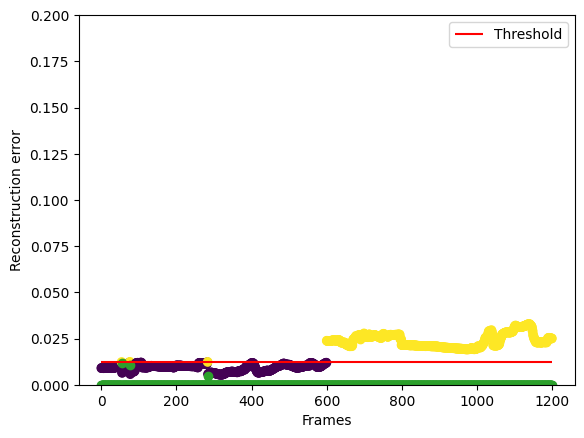

In [101]:
plt.scatter(np.arange(len(frame_errors)),frame_errors,c=preds)
plt.scatter(np.arange(len(new_frame_errors)),new_frame_errors,c="tab:green")
plt.hlines(y=THR,xmin=0,xmax=len(frame_errors),color="red",label="Threshold")
plt.xlabel("Frames")
plt.ylabel("Reconstruction error")
plt.ylim((0,0.2))
plt.legend(loc="best")